This script is the kappa0 analysis for each different station
Please modify the station name 
Please adjust the lower and upper frequency bounds where the slope will be calculated
note:
    the analysis carried out for continuous waveform recorded in 2019
    we didn't store the noise segment. 
    Everytime the code is running, they read the continuous data and trim it then perform the calculation
    

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from spectra import fas_psd_smooth
from gradient_to_kappa import gradient, kappa
from stats import bootstrap
from obspy import read, read_inventory
import seaborn as sns
# sns.set(style="whitegrid")
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
def trimsignal (tr, durtarget):
    import numpy.ma as ma
    tr_=tr.copy()
    start= tr_.stats.starttime
    raf=0.8
    relps = durtarget
    end  = start+relps*raf
    net= tr_.stats.network
    sta =tr_.stats.station
    loc = tr_.stats.location
    chan= tr_.stats.channel
    starttime=tr_.stats.starttime
    endtime= tr_.stats.endtime
    sampling_rate=tr_.stats.sampling_rate
    delta=tr_.stats.delta
    event_id= starttime
    year=str(starttime)[0:4]
    tr_.trim(start,end)
    
    if ma.is_masked(tr_.data)== False:
        
        if isinstance(tr_.data, np.ma.masked_array):
            tr_.data = tr_.data.filled()
        dest_dir =os.path.join("/Users/psuroyo/Downloads/Noise_trim",year,net,sta,chan,str(event_id))
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        os.chdir(dest_dir)
        return tr_.write(tr_.id+'_'+str(event_id),format="MSEED")

In [7]:
# 1. DEFINE INPUT (STATION ID, NETWORK ID, Freq bounds, Inventory); output directory
direc='/Users/psuroyo/Downloads/'
folder_year ='Noise_1/2019'
net= 'LV'
sta= 'L001'
lowerf, upperf =  15 , 40
pinv  = "/Users/psuroyo/Documents/Study_DataWork/PNR_TLS_Array/selected_mseed_p/Inventory/"
inv = read_inventory(os.path.join(pinv,'pnr_inventory.xml'),'stationxml')
durtarget = 600 #in second

dest_dir =os.path.join("/Users/psuroyo/Downloads/Noise_trim",'kappa_store')
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# 1. EXTRACT NOISE SIGNAL FROM CONTINUOUS WAVEFORM
please do not run this part if you already have the noise segments

In [328]:
# path = os.path.join(direc, folder_year,net, sta)
# list_ev = [f for f in os.listdir(path) if not f.startswith('.')]
# no_rec = 0
# for ev in list_ev:
#     list_rec = [f for f in os.listdir(os.path.join(path,ev)) if not f.startswith('.')]
#     if len(list_rec)==3:
#         no_rec += len(list_rec)
#         for rec in list_rec:
#             st  = read(os.path.join(path,ev,rec),format='mseed')
#             for tr in st:
#                 trimsignal (tr, durtarget)
# print("network: ", net)
# print("station: ", sta)
# print("total number of records: ", no_rec)    

# 2. MAIN SCRIPT TO CALCULATE KAPPA PER STATION, AVERAGE KAPPA, AVERAGE NORMALISED FAS. 

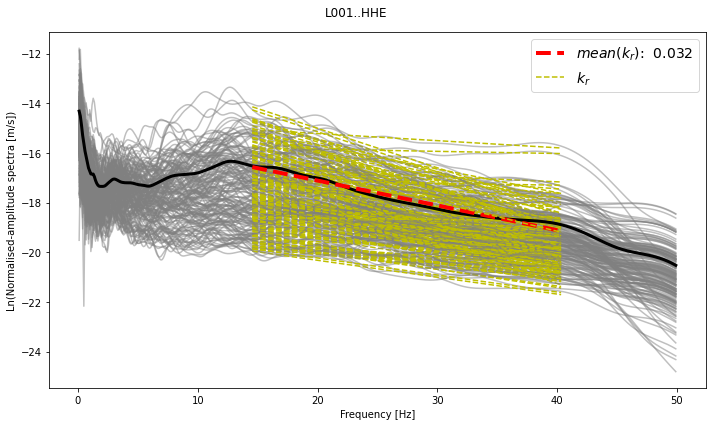

In [8]:
folder_noise ='Noise_trim/2019'
cha ='HHE'
out = 'VEL'
nfft = 1000
newpath = os.path.join(direc,folder_noise,net,sta,cha)
list_ev = [f for f in os.listdir(newpath) if not f.startswith('.')]

evid=[]
fall=[]
fasn=[]
kall=[]
call=[]
            
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
for ev in list_ev:
    s = read(os.path.join(newpath,ev,'*HH*'),format='mseed')
    if len(s)!= 1: 
        print('check number of traces and channel id')
        pass
    else:
        for tr in s:
            prefilter=[0.05,0.1,40,45]
            wl = 90
            tr.detrend("demean")
            tr.taper(max_percentage=0.05)
            try:
                tr.remove_response(inv, output=out, pre_filt=prefilter, 
                                   zero_mean=True, taper=True, taper_fraction=0.05)
            except:
                try:
                    # instrument response in seed format
                    path_dataless = '/Volumes/Samsung_T5/Secondment_GFZ/dataless' 
                    list_seed = [f for f in os.listdir(path_dataless) if not f.startswith('.')]
                    list_seed = [f for f in list_seed if f.endswith('_SEED')]
                    sta_id = sta + '_HH_'+ cha[-1]
                    insres_file = [f for f in list_seed if f.startswith(sta_id)]
                    if len(insres_file) >1:
                        dt=[]
                        for x in insres_file:
                            dates = (x.split('.')[-1]).split('_')
                            date = dates[0].split('-')
                            date = datetime.datetime.strptime((date[0]+'-'+date[1]+'-'+date[2]), '%Y-%m-%d')
                            dt.append(date)
                        dt_latest = max(dt).strftime("%Y-%m-%d")
                        inv_seed = [y for y in insres_file if dt_latest in y]
                        inv_seed = inv_seed[0]
                    else:
                        inv_seed = insres_file[0]
                    inv = read_inventory(os.path.join(path_dataless,inv_seed), format='SEED')
                    tr.remove_response(inv, output=out,  pre_filt=prefilter, water_level= wl)

                except:
                    try:
                        # instrument response in RESP format
                        path_dataless = '/Volumes/Samsung_T5/Secondment_GFZ/dataless' 
                        list_resp = [f for f in os.listdir(path_dataless) if not f.startswith('.')]
                        list_resp = [f for f in list_resp if f.startswith('RESP')]
                        sta_id = sta + '..HH'+ cha[-1]
                        insres_file = [f for f in list_resp if sta_id in f]
                        inv_resp = insres_file[0]
                        inv = read_inventory(os.path.join(path_dataless,inv_resp), format='RESP')
                        tr.remove_response(inv, output=out,  pre_filt=prefilter, water_level= wl)
                        print(tr)
                    except:
                        try:
                            path_dataless = os.path.join("/Users/psuroyo/Downloads/Noise_trim",'RESP.ALL')
                            seedresp = {'filename': path_dataless,
                                        'units': out}
                            tr.detrend("demean")
                            tr.detrend("linear")
                            tr.taper(max_percentage=0.05)
                            tr.simulate(paz_remove=None, seedresp=seedresp, water_level=100000)
                            tr.detrend("demean")
                            tr.detrend("linear")
                            tr.taper(max_percentage=0.05)
                            tr.filter("bandpass", freqmin=1., freqmax= 45)
                        except:
                            print("no instrument response found for: " + (ev + "_"+ tr.id) + "!")
                            pass
            f, fas, psd,smooth= fas_psd_smooth(tr, nfft, smoothing='konno-ohmachi',
                                                           smoothing_count=1, smoothing_constant=40)
            nor_fas = smooth/ len(smooth)
            coef,poly1d, x, y = gradient(lowerf, upperf, np.log(nor_fas), f)
            kr = kappa(coef[0])
            
            ax.plot(f, np.log(nor_fas), color='grey',alpha=0.5)
            ax.plot( x, poly1d(x), '--y')
            ax.set_ylabel('Ln(Normalised-amplitude spectra [m/s])')
            ax.set_xlabel('Frequency [Hz]')
#             ax.set_title('FAS-normalized')

            
            evid.append(ev)
            fall.append(f)
            fasn.append(nor_fas)
            kall.append(kr)
            call.append(coef[1])
            
#3. average plot

av_nfas = np.mean(fasn, axis=0)
av_f = np.mean(fall, axis=0)
coef1,poly1, x1, y1 = gradient  (lowerf, upperf, np.log(av_nfas),av_f)
k = kappa(coef1[0])        
ax.plot(av_f, np.log(av_nfas), color='k',linewidth=3.)
ax.plot( x, poly1(x), '--r',linewidth=4.,label='$mean (k_{r})$:  '+"{:.3f}".format(abs(k)))
ax.plot( x, poly1d(x), '--y',label='$k_{r}$ ')
ax.legend(loc='upper right', fontsize= 14)
fig.suptitle(sta+'..'+cha)
fig.tight_layout()
plt.savefig(os.path.join(dest_dir,sta+cha+str(lowerf)+'_'+str(upperf)+'.png'))

In [392]:
#save kappa for each records 
dk = pd.DataFrame({'rec_id':evid,'k_record':kall})
fn = 'kr_%s..%s.csv' % (sta,cha)
dk.to_csv(os.path.join(dest_dir,'kappa_recording',fn))

dfas = pd.DataFrame({'f':av_f, 'avg_fas':av_nfas})
dfas.to_csv(os.path.join(dest_dir,'fas_allrec',sta+'..'+cha+'.'+str(lowerf)+'_'+str(upperf)+'.csv'))

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


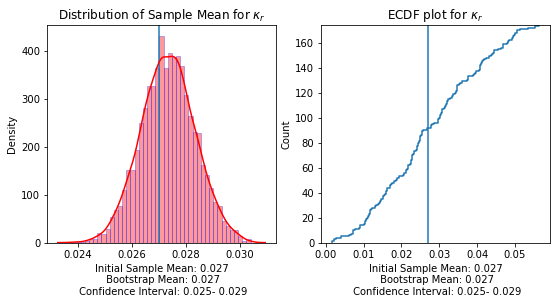

In [9]:
import numpy as np
import matplotlib
import seaborn as sns


v = kall
xbar_init = np.round(np.mean(v), 3)
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=False)
# generate 5000 resampled sample means  =>
means = [np.mean(np.random.choice(v,size=len(v),replace=True)) for i in range(5000)]
lower_ci = np.quantile(means, 0.025)
upper_ci = np.quantile(means, 0.975)
lower_ci, upper_ci
ax[0].set_xlabel("Initial Sample Mean: {:.3f}".format(xbar_init))
ax[0].set_title("Distribution of Sample Mean for $\kappa_{r}$")
ax[0].axvline(x=xbar_init) # vertical line at xbar_init
sns.distplot(means, color='r', kde=True, hist_kws=dict(edgecolor="b", linewidth=.675),ax=ax[0])
ax[1].set_xlabel("Initial Sample Mean: {}\n Bootstrap Mean: {:.3f}\n Confidence Interval: {:.3f}- {:.3f}".format(xbar_init,
                                                                                                                np.mean(means),
                                                                                                                lower_ci, upper_ci))
ax[0].set_xlabel("Initial Sample Mean: {}\n Bootstrap Mean: {:.3f}\n Confidence Interval: {:.3f}- {:.3f}".format(xbar_init,
                                                                                                                np.mean(means),
                                                                                                                lower_ci, upper_ci))
ax[1].set_title("ECDF plot for $\kappa_{r}$")
ax[1].axvline(x=xbar_init) # vertical line at xbar_init
sns.ecdfplot(data=kall,stat="count",ax=ax[1])
plt.show()

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


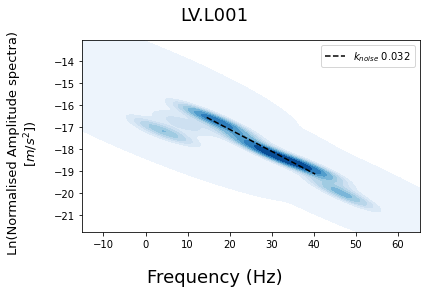

In [17]:

pols=np.poly1d([-k *(np.pi),coef1[1]])
fig,ax = plt.subplots()
sns.kdeplot(av_f, np.log(av_nfas), cmap="Blues", shade=True, thresh=0,ax=ax)
ax.plot(x1, (pols(x1)),'--k', label='$k_{noise}$ '+"{:.3f}".format(abs(k)))
fig.supylabel(" Ln(Normalised Amplitude spectra)\n [$m/s^{2}$])",fontsize=13,multialignment='center')
fig.supxlabel("Frequency (Hz)",fontsize=18)
fig.suptitle(net+'.'+sta,fontsize=18)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(dest_dir,sta+cha+str(lowerf)+'_'+str(upperf)+'_k0.png'))

------------------------- END, CONTINUE TO VISUALIZATION SCRIPT ---------------------------

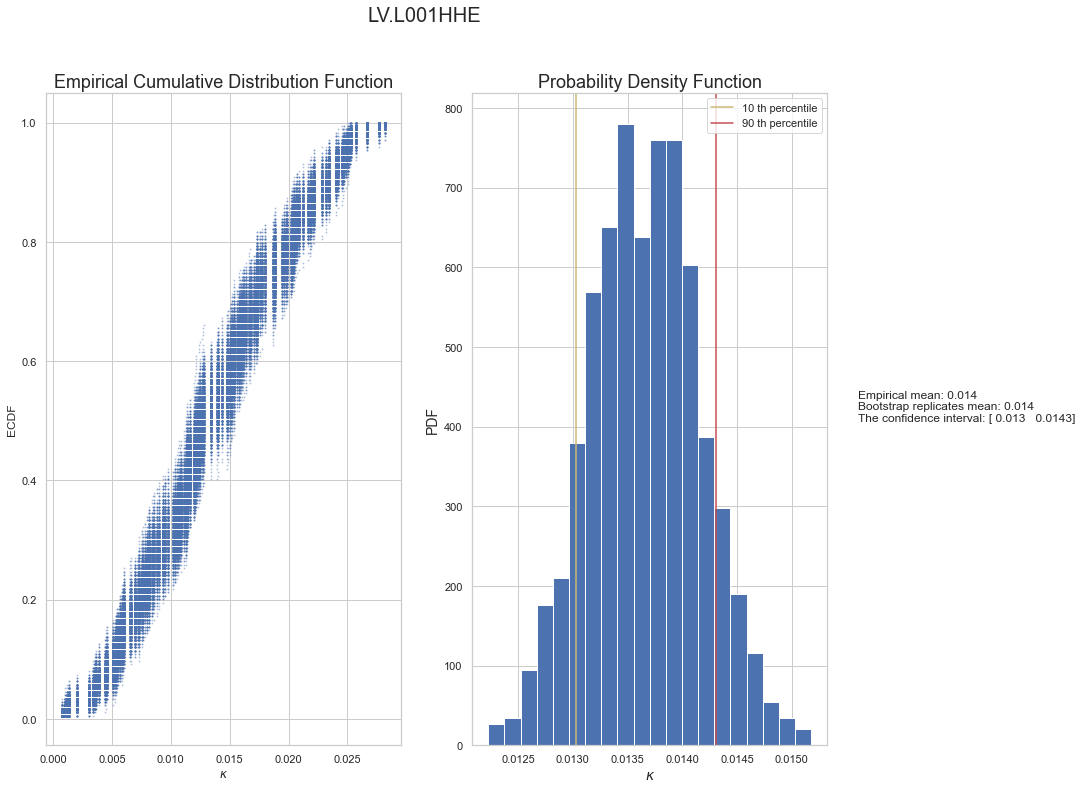

In [166]:
# 2. Distribution of kr using bootstrap
nbins, low, up = 20, 10, 90
kmean, k_interval, fig = bootstrap(kall, np.mean, nbins, low, up, (net+"."+sta+cha))

<AxesSubplot:ylabel='Count'>

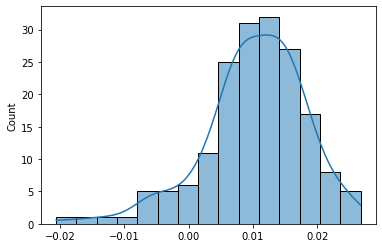

In [120]:
sns.histplot(data=kall,kde=True)

In [13]:
v

[-0.011023536635092869,
 -0.026698771009782858,
 -0.008927613036300153,
 0.027985616920941678,
 -0.0050031974497811525,
 -0.017799959775684684,
 -0.020842556227593522,
 -0.016585288552925289,
 -0.0044530127789728473,
 -0.0045685941493103684,
 -0.0066962806109937614,
 -0.018530742211197392,
 -0.007042564047704908,
 0.020932085536115152,
 -0.023057388124436091,
 0.030037686071542547,
 -0.037440331274800988,
 -0.021438972099398972,
 0.021231477363772032,
 -0.010864028854618662,
 -0.012259776209312991,
 0.0012363477650568842,
 -0.013526180115027675,
 0.0191061446117314,
 -0.010618866925904706,
 -0.0010205519844965396,
 -0.010451465509893737,
 0.030715687628306777,
 0.013526730050750989,
 -0.016681805553558995,
 -0.011365445373110263,
 0.0027870198730882358,
 -0.0091512734836421555,
 -0.015879168344217445,
 0.0144376384289571,
 -0.03839952739025311,
 -0.019911737740827124,
 -0.0064252722018363377,
 -0.012072220969862428,
 -0.015428711765763249,
 0.035678904627764046,
 -0.0068191966926605214